In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

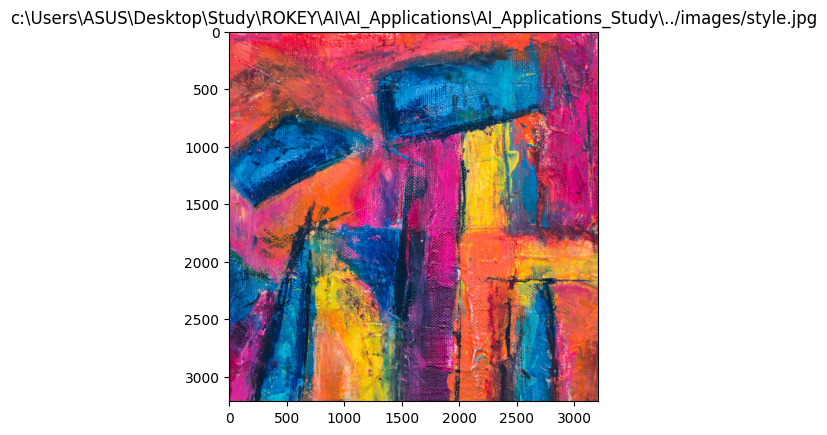

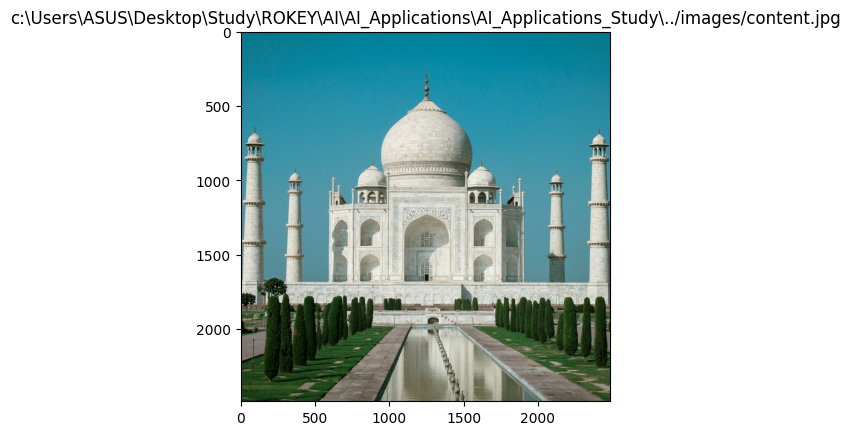

In [59]:
def image_to_tensor(image_filepath, image_dimension=128):
    img = Image.open(image_filepath).convert('RGB')

    plt.figure()
    plt.title(image_filepath)
    plt.imshow(img)

    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    return img.to(device, torch.float)

style_image = image_to_tensor(os.path.join(os.getcwd(), '../images/style.jpg'))
content_image = image_to_tensor(os.path.join(os.getcwd(), '../images/content.jpg'))

In [4]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch*num_channels, width*height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch*num_channels*width*height)

In [5]:
weights = torchvision.models.VGG19_Weights.DEFAULT
vgg19_model = torchvision.models.vgg19(weights=weights).to(device)
print(vgg19_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 54.0MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
vgg19_model = vgg19_model.features
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
for param in vgg19_model.parameters():
    param.requires_grad_(False)

In [12]:
vgg19_model[3]

ReLU(inplace=True)

In [13]:
conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'Maxpool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                      stride=vgg19_model[i].stride,
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, start=1))
print(vgg19_model)
print(conv_indices)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

In [17]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 20),
            nn.Linear(20, 30),
            nn.Linear(30, 40),
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = CustomModel()
x = torch.randn(1, 10)
print(x)
output = model(x)
print(output)
print(output.shape)

tensor([[-0.5145, -1.2144, -1.8618,  0.2540,  1.2511,  0.2556,  1.3533, -0.2888,
          0.5990, -1.5717]])
tensor([[ 0.3526,  0.0167,  0.0134, -0.2251,  0.0141,  0.0241,  0.2390, -0.2868,
          0.1013, -0.1272,  0.2734, -0.2493,  0.2888, -0.2167,  0.1033,  0.1559,
          0.0060, -0.3458,  0.1376,  0.2399, -0.2957, -0.2504, -0.3217,  0.1070,
         -0.2089,  0.1013, -0.2590,  0.1309, -0.0469,  0.1371, -0.1620,  0.1409,
          0.3785, -0.1010, -0.0951, -0.1442, -0.1791, -0.0408, -0.0053,  0.1069]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 40])


In [19]:
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU(),
    nn.Linear(30, 40),
)

x = torch.randn(1, 10)
output = model(x)
print(output.shape)

torch.Size([1, 40])


In [20]:
vgg_layers = nn.ModuleList(vgg19_model)
vgg_layers

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [21]:
display(conv_indices)

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

In [23]:
last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]
print(last_layer_idx)
vgg_layers_trimmed

10


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [24]:
neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])


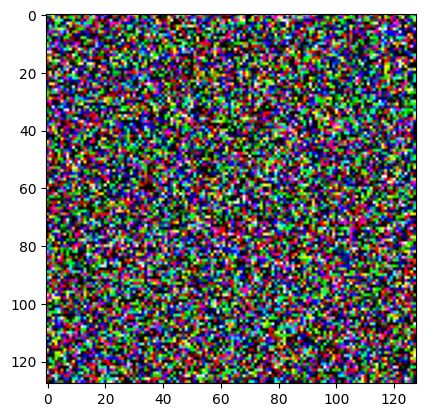

In [78]:
print(content_image.data.size())
ip_image = torch.randn(content_image.data.size(), device=device)
print(ip_image.shape)
print(ip_image.squeeze(0).shape)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1))
plt.show()

In [39]:
print(layers.keys())
print(layers)

dict_keys([1, 2, 3, 4, 5])
{1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}


In [40]:
ip_image.requires_grad_()

tensor([[[[ 3.7305e-01, -1.9159e-01,  5.7047e-01,  ..., -1.9406e-01,
           -8.5144e-01,  4.5908e-01],
          [ 8.2105e-02,  3.3542e-01,  9.6741e-01,  ..., -1.6541e+00,
           -2.1471e+00,  6.6321e-01],
          [-4.8191e-01,  1.9914e+00, -1.4321e+00,  ..., -1.0815e+00,
            5.3589e-01,  1.7044e-01],
          ...,
          [-5.9236e-03,  9.0198e-01, -1.2241e+00,  ...,  7.6839e-02,
            1.4542e-01, -5.5342e-01],
          [ 7.3890e-01,  1.7347e+00,  1.2551e+00,  ..., -7.0475e-01,
            7.4408e-01,  3.4784e-01],
          [-6.1152e-01,  7.0848e-01,  1.3679e-01,  ..., -9.4714e-01,
           -1.4923e+00, -1.4862e+00]],

         [[-1.0137e-01,  1.7950e-01,  6.9814e-01,  ...,  5.9963e-01,
           -5.4292e-01,  4.2995e-01],
          [ 6.4946e-01, -1.9321e-01, -2.3328e+00,  ..., -1.4956e+00,
           -7.4660e-01, -1.0369e+00],
          [-3.6883e-01,  1.5609e-01, -4.6030e-01,  ...,  2.7811e-01,
            3.9275e-02,  1.1396e+00],
          ...,
     

In [41]:
def gram_matrix(input_tensor):  
    batch, channels, height, width = input_tensor.size()  
    features = input_tensor.view(channels, height * width)  
    gram = torch.mm(features, features.t())  
    return gram  

epoch number 0
style_loss = 6497774080.000, content_loss = 24.136


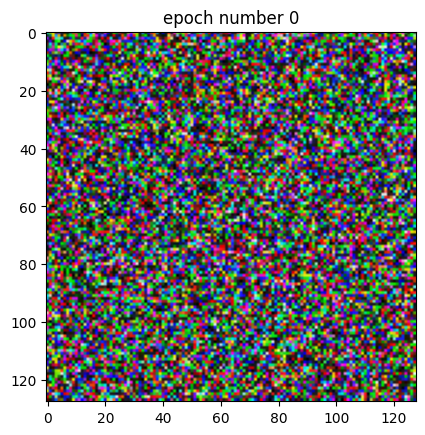

epoch number 500
style_loss = 454401.531, content_loss = 10.649


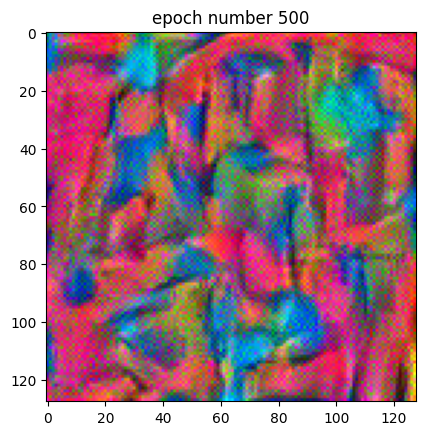

epoch number 1000
style_loss = 130200.922, content_loss = 10.710


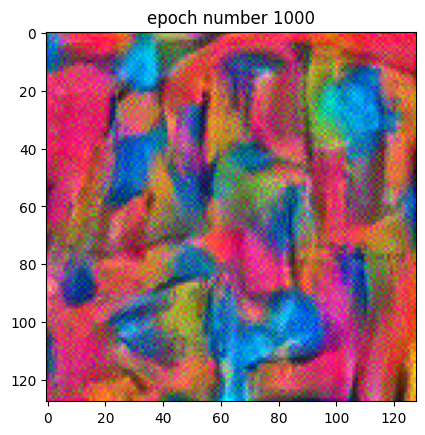

In [79]:
num_epochs = 1000
wt_style = 1
wt_content = 1
style_losses = []
content_losses = []
optimizer = optim.Adam([ip_image.requires_grad_()], lr=0.1)

for curr_epoch in range(num_epochs+1):

    ip_image.data.clamp_(0, 1)
    optimizer.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    optimizer.step()
    
    if curr_epoch % 500 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style_loss = {epoch_style_loss:.3f}, content_loss = {epoch_content_loss:.3f}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.show()
        
    style_losses.append(epoch_style_loss.item())
    content_losses.append(epoch_content_loss.item())

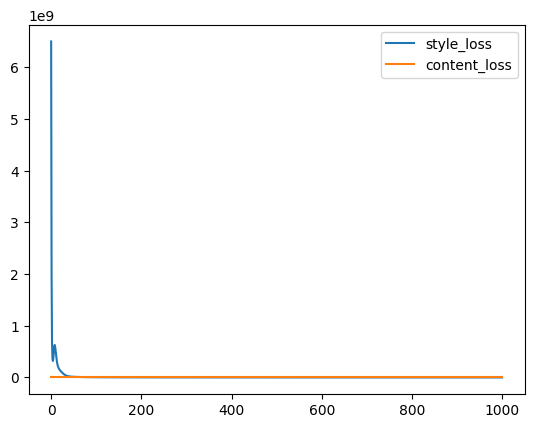

In [80]:
plt.plot(range(len(style_losses)), torch.tensor(style_losses), label='style_loss')
plt.plot(range(len(content_losses)), torch.tensor(content_losses), label='content_loss')
plt.legend()
plt.show()